In [1]:
!pip install ultralytics torchsummary

Looking in links: /kaggle/input/pm-72137641-at-12-03-2024-15-04-30/


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/__script__.py
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/fonttools-4.55.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/tzdata-2024.2-py2.py3-none-any.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/pm-72137641-at-12-03-2024-15-04-30/py_cpuinfo-9.0.0-py3-none-any.wh

In [3]:
import torch 
import os
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset
import cv2
from ultralytics import YOLO
import torch.nn as nn
import torch.optim as optim

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
os.chdir('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train')

In [5]:
for file in os.listdir():
    print(file)

Inclusion
Rolled
Pitted
Scratches
Patches
Crazing


In [6]:
image = cv2.imread('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train/Rolled/RS_126.bmp')

In [7]:
import matplotlib.pyplot as plt

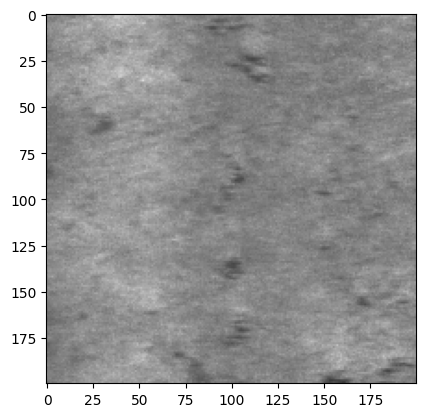

In [8]:
plt.imshow(image)

This should be simple case of image classification

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
valid_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

In [11]:
transformer_func = transforms.Compose([transforms.ToTensor()])

In [12]:
transformer_func

Compose(
    ToTensor()
)

In [13]:
train_data = ImageFolder(root = train_dir,transform=transformer_func)
valid_data = ImageFolder(root = valid_dir,transform=transformer_func)

In [14]:
train_loader = DataLoader(train_data,batch_size=32,num_workers=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=32,num_workers=4,shuffle=True)

In [15]:
for data,labels in train_loader:
    print(labels.shape)
    print(data.shape)
    break

torch.Size([32])
torch.Size([32, 3, 200, 200])


In [16]:
train_data.class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [17]:
#Creating a simple NN
class linearNN(nn.Module):
    def __init__(self):
        super(linearNN,self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_nn = nn.Sequential(
        
            nn.Linear(120000,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,6)
        )
    def forward(self,x):
        x = x.view(x.size(0),-1)
        return self.linear_nn(x)

In [18]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel,self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,padding=1,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.linearlayer = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(23*23*128,128),
            nn.ReLU(),
            nn.Linear(128,6)
    )
    def forward(self,x):
        x = self.convlayer(x)
        x = x.view(x.size(0),-1)
        x = self.linearlayer(x)
        return x

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
model = CNNmodel().to(device)

In [21]:
from torchsummary import summary

summary(model,input_size=(3,200,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Conv2d-4           [-1, 64, 98, 98]          18,496
              ReLU-5           [-1, 64, 98, 98]               0
         MaxPool2d-6           [-1, 64, 49, 49]               0
            Conv2d-7          [-1, 128, 47, 47]          73,856
              ReLU-8          [-1, 128, 47, 47]               0
         MaxPool2d-9          [-1, 128, 23, 23]               0
           Linear-10                  [-1, 128]       8,667,264
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 6]             774
Total params: 8,761,286
Trainable params: 8,761,286
Non-trainable params: 0
---------------------------

In [22]:
#testing if model and images work
for data,labels in train_loader:
    print(labels)
    y = (model(data.to(device)))
    y_pred = torch.argmax(torch.softmax(y,dim=1),dim=1)
    print(y_pred)
    break

tensor([4, 3, 2, 5, 5, 2, 1, 2, 2, 0, 5, 1, 2, 4, 1, 0, 4, 3, 2, 3, 2, 3, 4, 0, 4, 5, 3, 5, 2, 5, 4, 2])
tensor([2, 5, 2, 5, 2, 5, 2, 5, 2, 2, 5, 2, 2, 5, 2, 5, 5, 5, 5, 5, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [23]:
#hyperparams
epochs = 50
lre = 1e-04

In [24]:
optimizer = optim.Adam(model.parameters(),lr=lre)
loss_fn = nn.CrossEntropyLoss()

In [25]:
train_losses,test_losses = [],[]
train_accs,test_accs = [],[]
for epoch in range(epochs):
    model.train()
    train_loss,correct = 0,0
    for batch,(x,y) in enumerate(train_loader):
        x,y = x.to(device),y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
        correct += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = train_loss/len(train_loader)
    avg_acc = correct/len(train_loader)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f'Epoch {epoch} | loss: {avg_loss} | accuracy: {avg_acc}')

    with torch.no_grad():
        model.eval()
        test_loss,test_acc = 0,0
        for batch,(x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = test_loss/len(valid_loader)
    avg_acc = test_acc/len(valid_loader)
    test_losses.append(avg_loss)
    test_accs.append(avg_acc)
    print(f'Epoch {epoch} | test loss: {avg_loss} | test accuracy: {avg_acc}')
        
        
        

Epoch 0 | loss: 1.6690575572160573 | accuracy: 0.27283653846153844
Epoch 0 | test loss: 1.6090177694956462 | test accuracy: 0.3229166666666667
Epoch 1 | loss: 1.378765664421595 | accuracy: 0.49038461538461536
Epoch 1 | test loss: 1.1446714003880818 | test accuracy: 0.4895833333333333
Epoch 2 | loss: 0.9809184292188058 | accuracy: 0.6927083333333334
Epoch 2 | test loss: 0.7438715895016988 | test accuracy: 0.78125
Epoch 3 | loss: 0.7158484315642943 | accuracy: 0.7718349358974359
Epoch 3 | test loss: 0.5341570576032003 | test accuracy: 0.90625
Epoch 4 | loss: 0.5436319708824158 | accuracy: 0.8185096153846154
Epoch 4 | test loss: 0.37261682748794556 | test accuracy: 0.9270833333333334
Epoch 5 | loss: 0.441305877497563 | accuracy: 0.8487580128205128
Epoch 5 | test loss: 0.27286377052466076 | test accuracy: 0.9270833333333334
Epoch 6 | loss: 0.367480354813429 | accuracy: 0.8739983974358974
Epoch 6 | test loss: 0.23698207239309946 | test accuracy: 0.9375
Epoch 7 | loss: 0.3218198533241565 | a

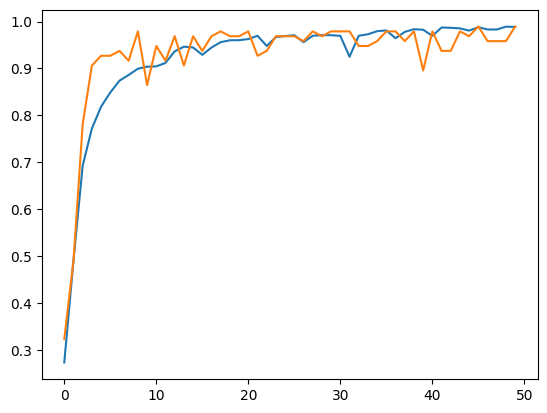

In [26]:
plt.plot(train_accs)
plt.plot(test_accs)

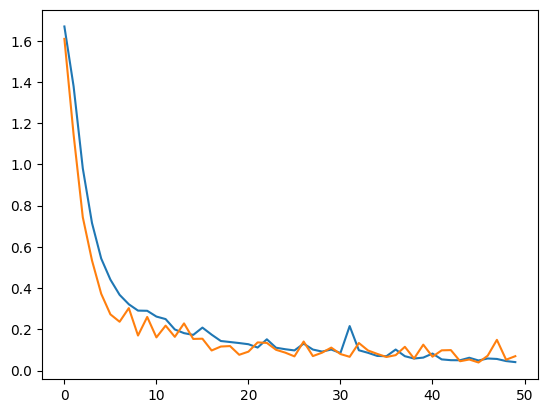

In [27]:
plt.plot(train_losses)
plt.plot(test_losses)

RESNET50 Fine tuning

In [28]:
tl_model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [29]:
#This will stop updating weights
for param in tl_model.parameters():
    param.requires_grad = False

In [30]:
#Modify FCN
num_classes = 6
tl_model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
input_tolinear = tl_model.fc.in_features
tl_model.fc =nn.Linear(input_tolinear,num_classes)
tl_model.to(device='cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
from torchsummary import summary

summary(tl_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
transformer_func = transforms.Compose([transforms.ToTensor(),transforms.Resize((224,224))])
train_data = ImageFolder(root = train_dir,transform=transformer_func)
valid_data = ImageFolder(root = valid_dir,transform=transformer_func)
train_loader = DataLoader(train_data,batch_size=32,num_workers=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=32,num_workers=4,shuffle=True)

In [33]:
tl_optimizer = optim.Adam(tl_model.parameters(),lr=lre)
loss_fn = nn.CrossEntropyLoss()

In [34]:
epochs= 50

In [35]:
train_losses,test_losses = [],[]
train_accs,test_accs = [],[]
for epoch in range(epochs):
    tl_model.train()
    train_loss,correct = 0,0
    for batch,(x,y) in enumerate(train_loader):
        x,y = x.to(device),y.to(device)
        pred = tl_model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        tl_optimizer.step()
        tl_optimizer.zero_grad()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
        correct += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = train_loss/len(train_loader)
    avg_acc = correct/len(train_loader)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f'Epoch {epoch} | loss: {avg_loss} | accuracy: {avg_acc}')

    with torch.no_grad():
        tl_model.eval()
        test_loss,test_acc = 0,0
        for batch,(x,y) in enumerate(valid_loader):
            x,y = x.to(device),y.to(device)
            pred = tl_model(x)
            loss = loss_fn(pred,y)
            test_loss += loss.item()
            y_pred_class = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(pred)
    avg_loss = test_loss/len(valid_loader)
    avg_acc = test_acc/len(valid_loader)
    test_losses.append(avg_loss)
    test_accs.append(avg_acc)
    print(f'Epoch {epoch} | test loss: {avg_loss} | test accuracy: {avg_acc}')
        
        
        

Epoch 0 | loss: 1.5067694966609662 | accuracy: 0.5482772435897436
Epoch 0 | test loss: 1.3299705982208252 | test accuracy: 0.65625
Epoch 1 | loss: 1.0266396231376207 | accuracy: 0.8924278846153846
Epoch 1 | test loss: 0.7826385498046875 | test accuracy: 0.9791666666666666
Epoch 2 | loss: 0.7417518393351481 | accuracy: 0.9324919871794872
Epoch 2 | test loss: 0.5318471093972524 | test accuracy: 1.0
Epoch 3 | loss: 0.5667501200850193 | accuracy: 0.9477163461538461
Epoch 3 | test loss: 0.3895448048909505 | test accuracy: 1.0
Epoch 4 | loss: 0.4574326087649052 | accuracy: 0.9555288461538461
Epoch 4 | test loss: 0.30732350548108417 | test accuracy: 1.0
Epoch 5 | loss: 0.3872119618149904 | accuracy: 0.9639423076923077
Epoch 5 | test loss: 0.2783060570557912 | test accuracy: 1.0
Epoch 6 | loss: 0.3421647336620551 | accuracy: 0.9571314102564104
Epoch 6 | test loss: 0.21348330875237784 | test accuracy: 1.0
Epoch 7 | loss: 0.29379019083885044 | accuracy: 0.9659455128205128
Epoch 7 | test loss: 0.

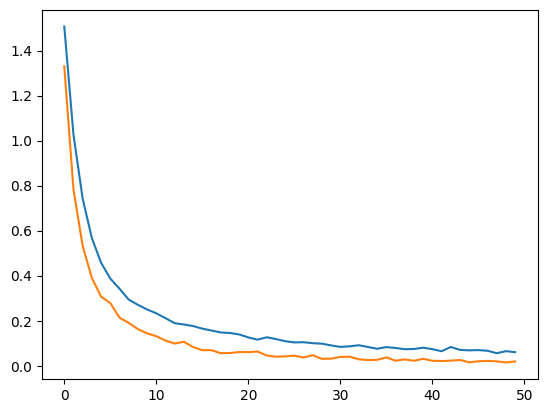

In [36]:
plt.plot(train_losses)
plt.plot(test_losses)

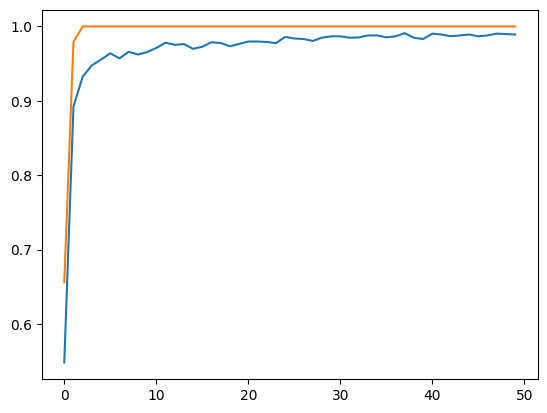

In [37]:
plt.plot(train_accs)
plt.plot(test_accs)

In [38]:
#Test accuracy is 100% Too much to believe